## Classification task

### Libraries

In [1]:
import os
import sys
sys.path.insert(0, '..')

import pandas as pd
import torch
import numpy as np
import dice_ml

from functools import partial
from torch import nn 
from classification_code.Classification import (
    analyze_class_imbalance, balance_dataset, main_classifier, final_train_classifier,
    compare_capping_methods, cap_outliers_IQR, NNClassifier
)
from classification_code.Autoencoder import Autoencoder
from classification_code.utils import OurDataset
from classification_code.xai import analyze_model


### Dataset preparation

In [3]:
train_dataset_path = "../dataset_classification/TrainDataset.csv"

# Features to be used in the model prediction
numerical_features = ['length', 'climb_total', 'profile', 'startlist_quality', 'cyclist_age', 'delta']
# Function to be applied to the dataframe before training the model, to bin the points/uci_points
def bin_points(df):
    bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
    labels = ['None', 'Very Low', 'Low', 'Medium', 'High', 'Very High', 'Exceptional']
    merged_points = np.ceil((df['uci_points'] * 0.5 + df['points'] * 0.5))
    df['points_category'] = pd.cut(merged_points, bins=bins, labels=labels, include_lowest=True)
    df = df.drop(columns=['uci_points', 'points'])

    return df

# Load the dataset and apply the bin_points function, also apply scaling and one-hot encoding
train_dataset = OurDataset(train_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])

train_dataset.data.sample(5)


,length,climb_total,profile,startlist_quality,cyclist_age,delta,points_category_High,points_category_Low,points_category_Medium,points_category_None,points_category_Very High,points_category_Very Low
381976,0.426536,1.760996,1.744092,-0.600712,-0.903912,-0.497707,0.0,0.0,0.0,1.0,0.0,0.0
46913,-2.479168,-1.626083,-0.451282,-0.542935,0.146333,-0.677527,0.0,0.0,0.0,1.0,0.0,0.0
94609,0.406549,1.259889,1.744092,-0.059707,-1.166473,-0.642723,0.0,0.0,0.0,1.0,0.0,0.0
366557,0.257421,1.000882,1.744092,-1.745752,0.671455,-0.544112,0.0,0.0,0.0,1.0,0.0,0.0
62553,-0.995568,-1.436247,-1.183073,1.518661,-0.378789,0.556427,0.0,0.0,0.0,1.0,0.0,0.0


### Exploring the classes imbalance

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Class Distribution:
Class 1.0: 86602 samples (15.41%)
Class 0.0: 475369 samples (84.59%)

Imbalance Ratio: 5.49


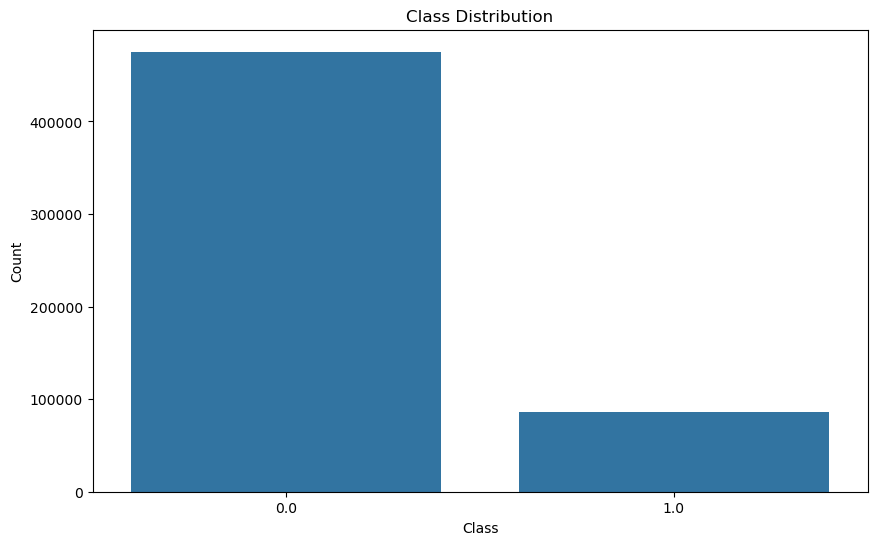

(Counter({0.0: 475369, 1.0: 86602}), 5.489122653056511)

In [4]:
train_labels = train_dataset.labels
# Check the class imbalance
analyze_class_imbalance(train_labels)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Class Distribution:
Class 1.0: 475369 samples (50.00%)
Class 0.0: 475369 samples (50.00%)

Imbalance Ratio: 1.00


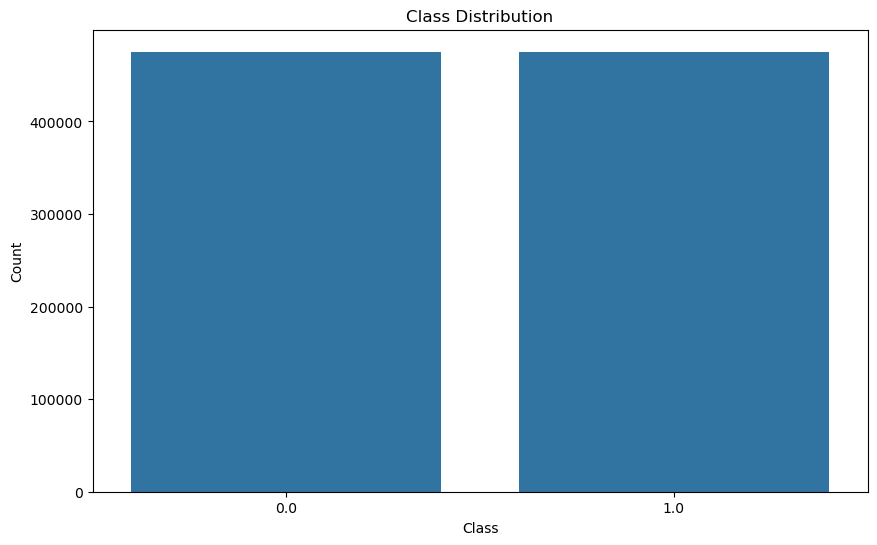

In [4]:
# Balance the dataset using SMOTE
balanced_dataset, y_balanced = balance_dataset(train_dataset.data, train_labels, method="smote")

train_dataset.update_data(balanced_dataset, y_balanced)

analyze_class_imbalance(y_balanced)
del balanced_dataset, y_balanced


In [5]:
results, capped_percentages = compare_capping_methods(train_dataset.data[numerical_features])
# Prints IQR and Z-score possible capping values, kind of capping selection
print("Original Data Statistics:")
print(train_dataset.data[numerical_features].agg(['min', 'max', 'mean', 'std']).round(3))
print("\nPercentage of values capped by each method:")
for method, percentage in capped_percentages.items():
    print(f"{method}: {percentage}% of values capped")

Original Data Statistics:
      length  climb_total  profile  startlist_quality  cyclist_age   delta
min   -2.556       -1.804   -1.183             -2.605       -7.468  -0.728
max    2.625        3.554    1.744              2.469        4.347  16.777
mean  -0.000        0.023    0.026             -0.093       -0.032   0.207
std    1.017        0.994    0.974              1.004        0.967   1.082

Percentage of values capped by each method:
Conservative (2.0 IQR): 1.9% of values capped
Standard (1.5 IQR): 2.98% of values capped
Aggressive (1.0 IQR): 6.17% of values capped
Z-score (3 std): 0.07% of values capped
Z-score (2.5 std): 0.44% of values capped
Z-score (2 std): 3.94% of values capped


In [6]:
# We decided to use the IQR method with a multiplier of 2.0 (Conservative)
train_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)

print(train_dataset.data[numerical_features].agg(['min', 'max', 'mean', 'std']).round(3))

      length  climb_total  profile  startlist_quality  cyclist_age  delta
min   -1.855       -1.804   -1.183             -2.605       -3.610 -0.728
max    2.204        3.474    1.744              2.469        3.526  5.141
mean   0.047        0.023    0.026             -0.093       -0.032  0.206
std    0.911        0.994    0.974              1.004        0.967  1.070


### Training the classifier

In [7]:
main_classifier(
    data=train_dataset.to_tensor(), labels=train_dataset.label_tensor,
    num_samples=10, max_num_epochs=20
)

2025-01-05 13:50:39,063	INFO worker.py:1821 -- Started a local Ray instance.
2025-01-05 13:50:39,756	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-05 13:50:39,768	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-01-05_13-41-15.json
2025-01-05 13:50:39,792	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier' in 0.0081s.
2025-01-05 13:50:39,797	INFO tune.py:1041 -- Total run time: 0.04 seconds (0.00 seconds for the tuning loop).


Best trial config: {'hidden_dims': [32, 96, 16], 'batch_size': 128, 'act_fn': LeakyReLU(negative_slope=0.01), 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'dropout': 0.07780308171101662, 'config_optimizer': {'weight_decay': 0.00010954871639140185, 'lr': 0.009565510925024952}}
Best combined metrics: 0.6945723384618758
Best validation loss: 0.3008629739284515
Best validation F1: 0.7506848931312561
Best validation AUROC: 0.9393227577209473
Best checkpoint path: Checkpoint(filesystem=local, path=/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier/train_classifier_wrapper_5b80d_00009_9_act_fn=ref_ph_65afb126,batch_size=128,lr=0.0096,weight_decay=0.0001,dropout=0.0778,hidden_d_2025-01-05_01-09-40/checkpoint_000000)


I0000 00:00:1736081440.090448  552958 chttp2_transport.cc:1182] ipv4:172.19.22.214:65025: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {created_time:"2025-01-05T13:50:40.09043838+01:00", http2_error:2, grpc_status:14}


(train_classifier_wrapper_5b80d_00009,
 {'hidden_dims': [32, 96, 16],
  'batch_size': 128,
  'act_fn': LeakyReLU(negative_slope=0.01),
  'optimizer': torch.optim.adamw.AdamW,
  'dropout': 0.07780308171101662,
  'config_optimizer': {'weight_decay': 0.00010954871639140185,
   'lr': 0.009565510925024952}},
 Checkpoint(filesystem=local, path=/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier/train_classifier_wrapper_5b80d_00009_9_act_fn=ref_ph_65afb126,batch_size=128,lr=0.0096,weight_decay=0.0001,dropout=0.0778,hidden_d_2025-01-05_01-09-40/checkpoint_000000))

In [8]:
# Based on the results of the previous cell, we will use the following configuration for the final classifier
# Train the final classifier with full dataset
data = train_dataset.to_tensor()
y = train_dataset.label_tensor

config = {
    "input_dim": data.shape[1],
    "hidden_dims": [32, 128, 16],
    "batch_size": 128,
    "act_fn": nn.LeakyReLU(negative_slope=0.15),
    "optimizer": torch.optim.AdamW,
    "dropout": 0.3,
    "monitor": "train_loss",
    "max_epochs": 40,
    "model_save_path": "models/classifier",
}

trainer_config = {
    "accelerator": "gpu",
    "devices": 1,
    "strategy": "auto",
    "precision": 32,
    "enable_progress_bar": True,
}
optimizer_params = {
    "lr": 0.01,
    "weight_decay": 0.00011,
}


config["optimizer_params"] = optimizer_params
config["trainer_config"] = trainer_config

classifier = final_train_classifier(data, y, **config)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | loss_function | BCEWithLogitsLoss | 0      | train
1 | model         | Sequential        | 7.1 K  | train
2 | train_acc     | BinaryAccuracy    | 0      | train
3 | val_acc       | BinaryAccuracy    | 0      | train
4 | f1_score      | BinaryF1Score     | 0      | train
5 | auroc         | BinaryAUROC       | 0      | train
------------------------------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)
17

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


Creating the folders for the model: /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/classifier, if they do not exist.
With the model name: NNClassifier_20250105135041
Saving the model to: /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/classifier/NNClassifier_20250105135041


In [9]:
import torchmetrics
# Load the test dataset and apply the same transformations as the training dataset
test_dataset_path = "../dataset_classification/TestDataset.csv"
test_dataset = OurDataset(test_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])
test_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)
# Check the statistics of the test dataset
print(train_dataset.data[numerical_features].agg(['min', 'max', 'mean', 'std']).round(3))

test_data = test_dataset.to_tensor()
test_y = test_dataset.label_tensor
# Evaluate the model on the test dataset
classifier.eval()
with torch.no_grad():
    test_pred = classifier(test_data)
    test_pred = torch.sigmoid(test_pred).round().squeeze()

test_acc = torchmetrics.Accuracy(task='binary', num_classes=2)
val_acc = torchmetrics.Accuracy(task='binary', num_classes=2)
f1_score = torchmetrics.F1Score(task='binary', num_classes=2)
auroc = torchmetrics.AUROC(task='binary', num_classes=2)
# Compute the metrics
print(f"Test Accuracy: {test_acc(test_pred, test_y)}")
print(f"Test F1 Score: {f1_score(test_pred, test_y)}")
print(f"Test AUROC: {auroc(test_pred, test_y)}")


      length  climb_total  profile  startlist_quality  cyclist_age  delta
min   -1.855       -1.804   -1.183             -2.605       -3.610 -0.728
max    2.204        3.474    1.744              2.469        3.526  5.141
mean   0.047        0.023    0.026             -0.093       -0.032  0.206
std    0.911        0.994    0.974              1.004        0.967  1.070
Test Accuracy: 0.9413676261901855
Test F1 Score: 0.7603649497032166
Test AUROC: 0.8397568464279175


INFO:classification_code.xai:Generating SHAP explanations...


  0%|          | 0/600 [00:00<?, ?it/s]

INFO:classification_code.xai:Setting up LIME explainer...
INFO:classification_code.xai:Data interface: <dice_ml.data_interfaces.public_data_interface.PublicData object at 0x740b0bbe66c0>
INFO:classification_code.xai:Initializing DiCE explainer...
INFO:classification_code.xai:Predicting probabilities...
100%|██████████| 1/1 [01:12<00:00, 72.45s/it]


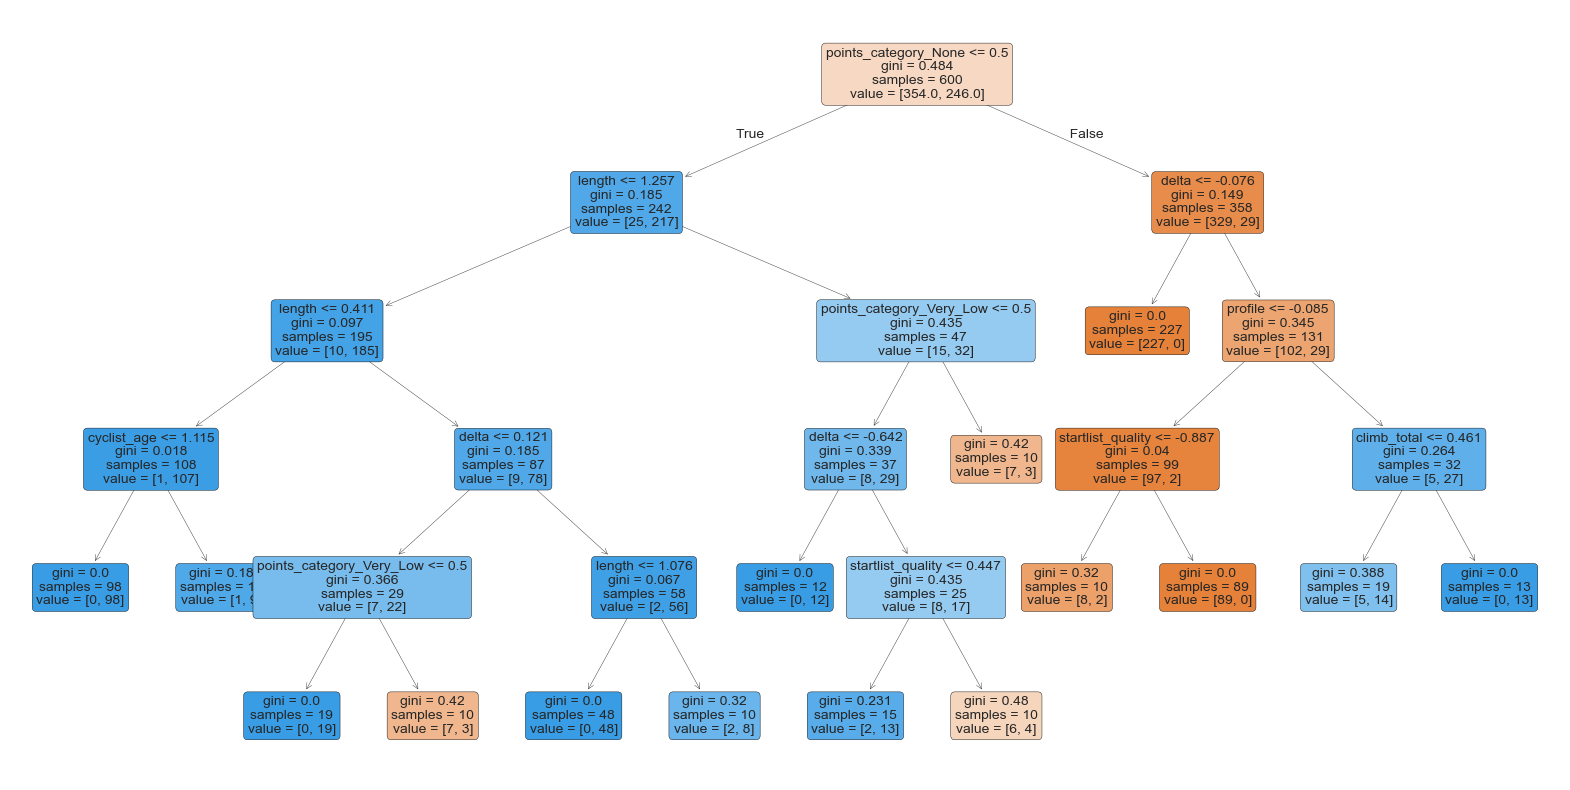

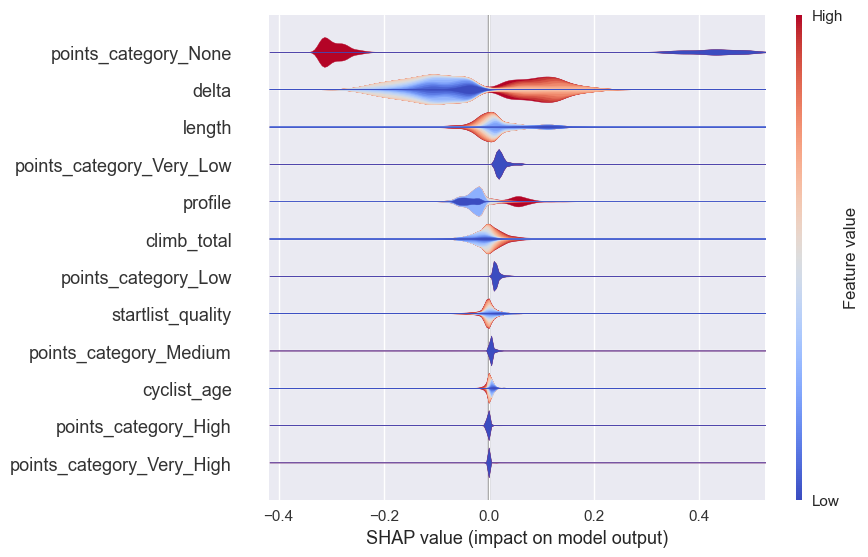

100%|██████████| 1/1 [01:02<00:00, 62.68s/it]

Query instance (original outcome : 20)


,length,climb_total,profile,startlist_quality,cyclist_age,delta,points_category_High,points_category_Low,points_category_Medium,points_category_None,points_category_Very_High,points_category_Very_Low,prediction
0,-0.861798,-1.394741,-1.177034,1.838223,0.275038,1.453071,0.0,0.0,0.0,0.0,1.0,0.0,20



Diverse Counterfactual set (new outcome: 0)


,length,climb_total,profile,startlist_quality,cyclist_age,delta,points_category_High,points_category_Low,points_category_Medium,points_category_None,points_category_Very_High,points_category_Very_Low,prediction
0,-,-1.13809198,-1.1771342588418605,-,-,-,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
1,1.3600163,-,-1.1771342588418605,-,-,-,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
2,-0.5078387,-,-1.1771342588418605,-,-,-,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
3,-,-,-1.1771342588418605,-,3.22458487,-,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
4,-,-,-1.1771342588418605,-,1.78348941,-,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
5,-,-,-1.1771342588418605,-,-,0.4954701,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
6,-,-,-1.1771342588418605,-,-,2.3580317,0.0,0.0,0.0,1.0,1.0,0.0,-2.0
7,-,-,-1.1771342588418605,-,-,-,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
8,-,-,1.52381061,-,-,-,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,-,-,-1.1771342588418605,-,-,-,0.0,1.0,0.0,1.0,1.0,0.0,-1.0


{'feature_importance': {'top_features': [{'feature': 'length',
    'importance': [-0.037018899872317775,
     0.1418182751904075,
     0.14722769860470164,
     -0.017414881949517444,
     -0.010973181378235258,
     -0.058874953428122066,
     0.0005660096987953077,
     0.030845842948682485,
     0.016038939884238976,
     0.4227301828087868,
     0.0017414255532667152,
     -0.19969775305519016]},
   {'feature': 'climb_total',
    'importance': [-0.012932577144516986,
     0.14086908072178847,
     0.07851461620355131,
     0.0008905719950913112,
     0.008982251001112723,
     -0.123886410902545,
     -0.0024486770083709305,
     0.012312002865431498,
     0.004411793119161436,
     -0.272879031855125,
     0.0016053954721613947,
     0.013201689296072544]},
   {'feature': 'profile',
    'importance': [-0.0358600187020936,
     0.13578754861674253,
     0.14830546962467522,
     -0.018232536594928704,
     -0.01604474705622851,
     -0.07827479653739187,
     -0.001429442303326559,

<Figure size 800x550 with 0 Axes>

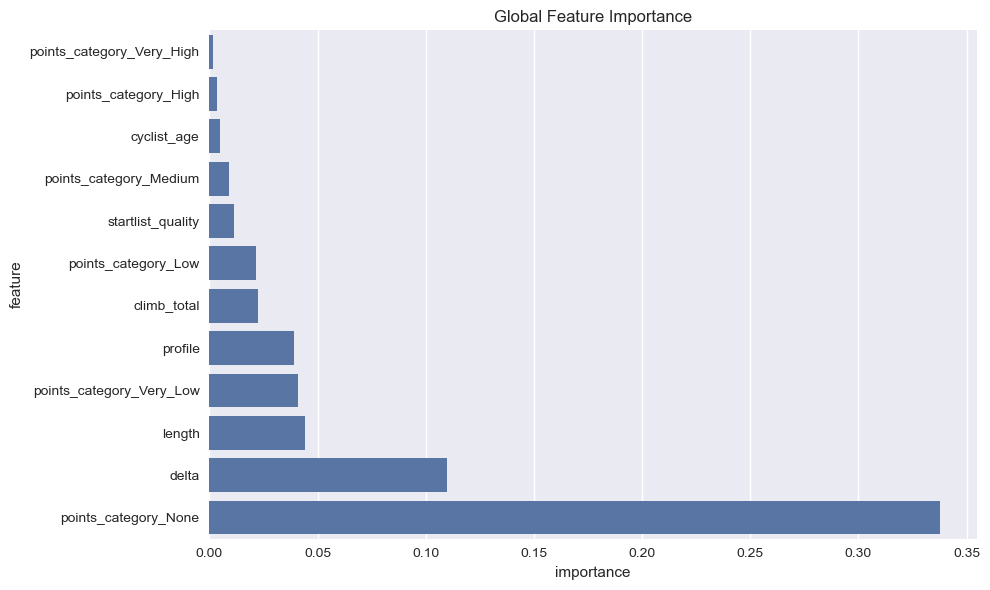

<Figure size 1000x600 with 0 Axes>

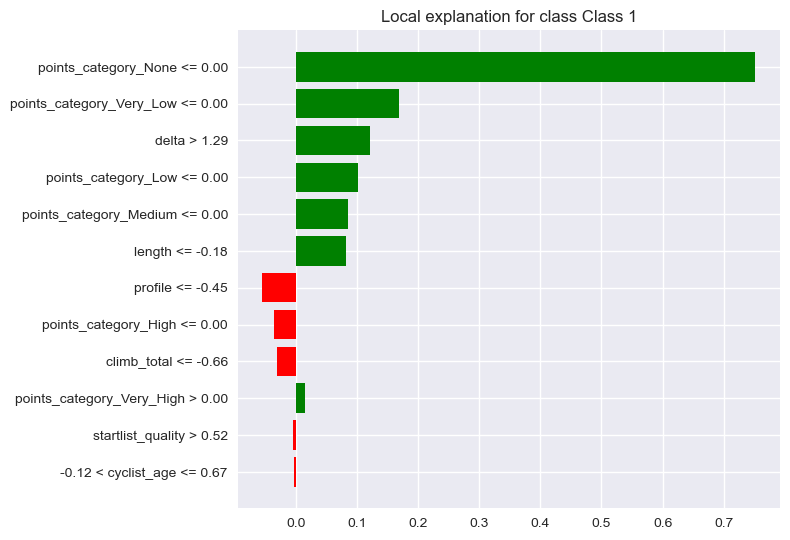

<Figure size 1200x600 with 0 Axes>

In [1]:
import warnings
import pandas as pd
import torch
import numpy as np
import dice_ml

from functools import partial
from torch import nn 
from classification_code.Classification import balance_dataset, cap_outliers_IQR, NNClassifier
from classification_code.utils import OurDataset
from classification_code.xai import analyze_model

from classification_code.Classification import NNClassifier
# The same process as before, but now we will use the trained model to generate Counterfactuals/Explanations
warnings.filterwarnings("ignore", category=FutureWarning)
state_dict = torch.load("../models/classifier/NNClassifier_20250105050134", weights_only=True)

def bin_points(df):
    bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
    labels = ['None', 'Very_Low', 'Low', 'Medium', 'High', 'Very_High', 'Exceptional']
    merged_points = np.ceil((df['uci_points'] * 0.5 + df['points'] * 0.5))
    df['points_category'] = pd.cut(merged_points, bins=bins, labels=labels, include_lowest=True)
    df = df.drop(columns=['uci_points', 'points'])

    return df
train_dataset_path = "../dataset_classification/TrainDataset.csv"
test_dataset_path = "../dataset_classification/TestDataset.csv"
numerical_features = ['length', 'climb_total', 'profile', 'startlist_quality', 'cyclist_age', 'delta']


train_dataset = OurDataset(train_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])
train_labels = train_dataset.labels
test_dataset = OurDataset(test_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])

balanced_dataset, y_balanced = balance_dataset(train_dataset.data, train_labels, method="smote")

train_dataset.update_data(balanced_dataset, y_balanced)

train_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)
test_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features)

config_local = {
    "input_dim": train_dataset.shape[1],
    "hidden_dims": [32, 128, 16],
    "act_fn": nn.LeakyReLU(negative_slope=0.15),
    "optimizer": torch.optim.AdamW,
    "dropout": 0.3,
}

classifier = NNClassifier(**config_local)
classifier.load_state_dict(state_dict)

# Sample the data to generate the Counterfactuals/Explanations
feature_names=train_dataset.data.columns
num_samples_train = 600 // 2
num_samples_test = 600 // 2
#Balancing the classes
train_class_1 = train_dataset.data[train_dataset.labels == 1]
train_class_2 = train_dataset.data[train_dataset.labels == 0]
train_sample_1 = train_class_1.sample(n=num_samples_train)
train_sample_2 = train_class_2.sample(n=num_samples_train)
X_train = pd.concat([train_sample_1, train_sample_2]).values.astype(np.float32)

test_class_1 = test_dataset.data[test_dataset.labels == 1]
test_class_2 = test_dataset.data[test_dataset.labels == 0]
test_sample_1 = test_class_1.sample(n=num_samples_test)
test_sample_2 = test_class_2.sample(n=num_samples_test)
X_test = pd.concat([test_sample_1, test_sample_2]).values.astype(np.float32)

# Evaluate the model on the test dataset
classifier.eval()
with torch.no_grad():
    test_pred = classifier(torch.tensor(X_test))
    predictions = torch.sigmoid(test_pred).round().squeeze()



continuous_features = [
    'length', 
    'climb_total',
    'profile',
    'startlist_quality',
    'cyclist_age',
    'delta'
]
# Configuration for the Counterfactuals
cf_params = {
        'features_to_vary': 'all',
        'verbose': False,
        'total_CFs': 20,
        'desired_class': 0,

}


dice_df = pd.DataFrame(X_train, columns=feature_names)
dice_df['prediction'] = pd.Series(predictions.squeeze().numpy())
encoded_categories = [col for col in dice_df.columns if col.startswith('points_category_')]
# Data interface for the Counterfactuals
d = dice_ml.Data(
    dataframe=dice_df,
    continuous_features=continuous_features,
    categorical_features=['points_category'],
    outcome_name='prediction',
    features_to_vary=continuous_features + ['points_category'],
    permitted_range={
        col: [0, 1] for col in encoded_categories  # Binary range for one-hot encoded features
    }
)
# Generate the Counterfactuals/Explanations
analyze_model(
    model=classifier, X_train=X_train, X_test=X_test, 
    feature_names=train_dataset.data.columns, save_dir="models/xai_results",
    data_interface=d, cf_params=cf_params
)
